In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms


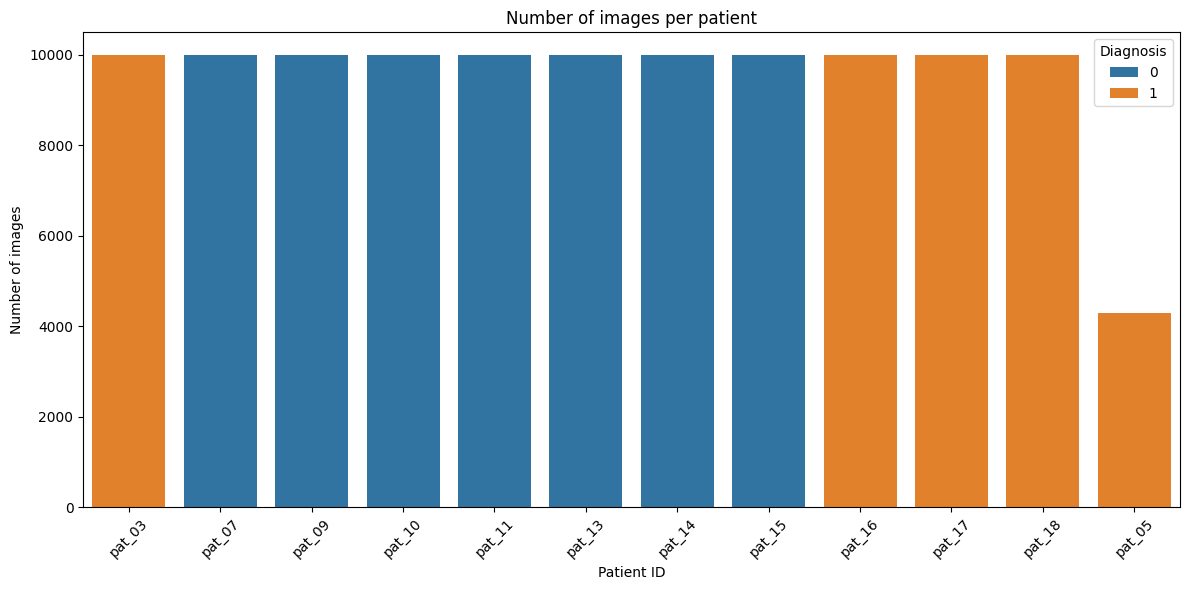

In [6]:
df = pd.read_csv('multimodal-cancer-classification-challenge-2025/train.csv')

# Extract patient_id and image_id from filenames
df['patient_id'] = df['Name'].str.extract(r'(pat_\d+)')
df['image_id'] = df['Name'].str.extract(r'image_(\d+)').astype(int)

# Patient-level statistics
patient_stats = df.groupby('patient_id').agg(
    Diagnosis=('Diagnosis', 'first'),
    image_count=('Name', 'count')
).reset_index()

# Plot number of images per patient, colored by diagnosis
plt.figure(figsize=(12, 6))
sns.barplot(data=patient_stats.sort_values("image_count", ascending=False),
            x="patient_id", y="image_count", hue="Diagnosis", dodge=False)
plt.title("Number of images per patient")
plt.xticks(rotation=45)
plt.xlabel("Patient ID")
plt.ylabel("Number of images")
plt.tight_layout()
plt.show()


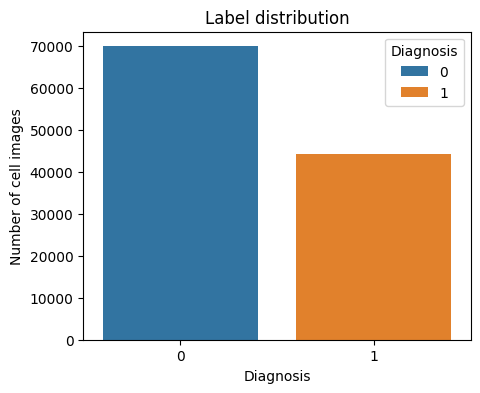

Diagnosis
0    70000
1    44302
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='Diagnosis', hue='Diagnosis')
plt.title('Label distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Number of cell images')
plt.show()
print(df['Diagnosis'].value_counts())

In [6]:
BF_PATH = 'multimodal-cancer-classification-challenge-2025/BF/train/'
FL_PATH = 'multimodal-cancer-classification-challenge-2025/FL/train/'

def show_random_pairs(df, diagnosis_label, num_samples=5):
    sampled = df[df['Diagnosis'] == diagnosis_label].sample(num_samples, random_state=1)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2))
    fig.suptitle(f'BF & FL samples from diagnosis {diagnosis_label} patients', fontsize=16)

    for i, (_, row) in enumerate(sampled.iterrows()):
        name = row['Name']
        bf_img = Image.open(os.path.join(BF_PATH, name))
        fl_img = Image.open(os.path.join(FL_PATH, name))

        axes[i, 0].imshow(bf_img)
        axes[i, 0].set_title(f'BF - {name}')
        axes[i, 1].imshow(fl_img, cmap='gray')
        axes[i, 1].set_title(f'FL - {name}')
        
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [26]:
def plot_image_intensity_stats(stats_csv):
    stats_df = pd.read_csv(stats_csv)

    for metric in ['mean', 'std', 'min', 'max']:
        plt.figure(figsize=(14, 5))
        sns.violinplot(data=stats_df, x='type', y=metric, hue='label', split=False, dodge=True)
        plt.title(f'{metric.capitalize()} intensity per image (BF vs FL)')
        plt.legend(title='Diagnosis', loc='upper right')
        plt.tight_layout()
        plt.show()

    for modality in ['BF', 'FL']:
        plt.figure(figsize=(14, 5))
        for lbl in [0, 1]:
            subset = stats_df[(stats_df['type'] == modality) & (stats_df['label'] == lbl)]
            sns.histplot(subset['mean'], label=lbl, kde=True, stat='density')
        plt.title(f'Mean intensity distribution - {modality}')
        plt.legend(title='Diagnosis', loc='upper right')
        plt.xlabel('Mean intensity')
        plt.tight_layout()
        plt.show()

In [27]:
def plot_image_intensity_stats_unlabeled(stats_csv):
    stats_df = pd.read_csv(stats_csv)

    # Violin plots by modality only (no labels)
    for metric in ['mean', 'std', 'min', 'max']:
        plt.figure(figsize=(14, 5))
        sns.violinplot(data=stats_df, x='type', y=metric)
        plt.title(f'{metric.capitalize()} intensity per image (BF vs FL)')
        plt.tight_layout()
        plt.show()

    # Histogram of mean intensity (no label split)
    for modality in ['BF', 'FL']:
        subset = stats_df[stats_df['type'] == modality]
        plt.figure(figsize=(14, 5))
        sns.histplot(subset['mean'], kde=True, stat='density', label=modality)
        plt.title(f'Mean intensity distribution - {modality}')
        plt.xlabel('Mean intensity')
        plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

In [28]:
def plot_train_vs_test_mean_histograms_combined(train_csv, test_csv):
    # Load stats
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    for modality in ['BF', 'FL']:
        # Filter by modality
        train_subset = train_df[train_df['type'] == modality]['mean']
        test_subset = test_df[test_df['type'] == modality]['mean']

        # Plot
        plt.figure(figsize=(12, 6))
        sns.histplot(train_subset, label="Train", kde=True, stat='density', alpha=0.5)
        sns.histplot(test_subset, label="Test", kde=True, stat='density', alpha=0.5)

        plt.title(f'Mean intensity distribution {modality} - Train (combined) vs. Test')
        plt.xlabel('Mean intensity')
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()
        plt.show()

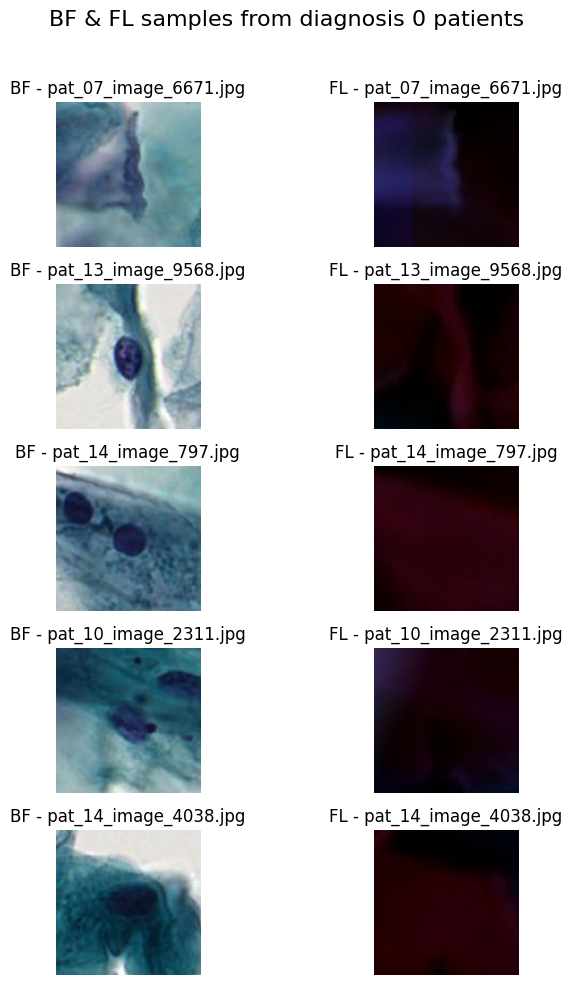

In [34]:
show_random_pairs(df, 0)

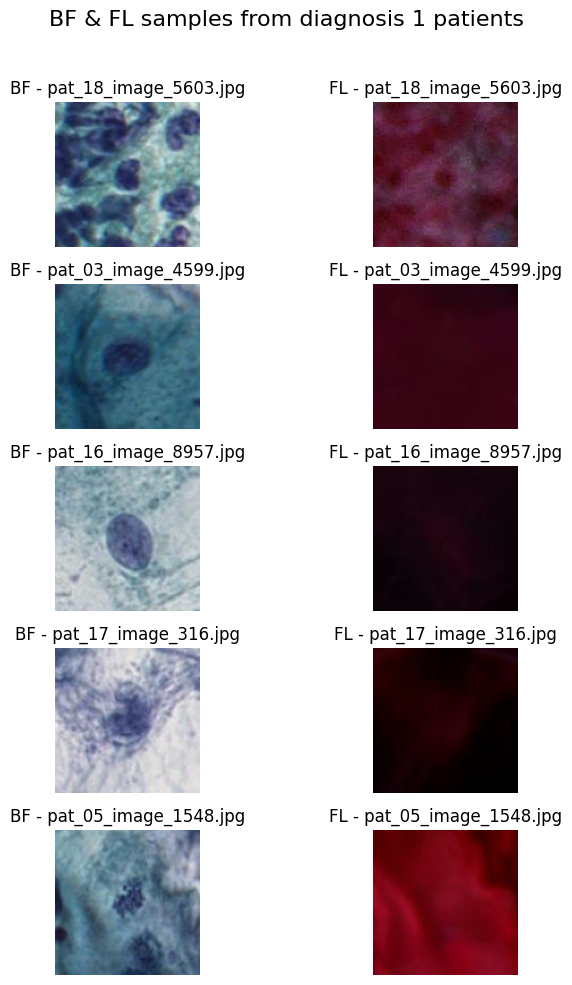

In [35]:
show_random_pairs(df, 1)

In [1]:
from image_intensity_processing import compute_image_intensity_stats, compute_test_image_intensity_stats_from_folder

In [ ]:
compute_image_intensity_stats(df, bf_path=BF_PATH, fl_path=FL_PATH)

Starting processing with ProcessPoolExecutor


Processing images: 100%|██████████| 114302/114302 [00:18<00:00, 6182.60it/s]


Done processing with ProcessPoolExecutor
Saved intensity statistics to image_intensity_stats.csv


In [2]:
compute_test_image_intensity_stats_from_folder(fl_path='multimodal-cancer-classification-challenge-2025/FL/test',
                                               bf_path='multimodal-cancer-classification-challenge-2025/BF/test',
                                               output_csv='test_image_intensity_stats.csv')


Scanning test images...
Found 59040 FL test images. Starting processing...


Processing test images: 100%|██████████| 59040/59040 [00:08<00:00, 7181.54it/s]


Saved test image statistics to: test_image_intensity_stats.csv


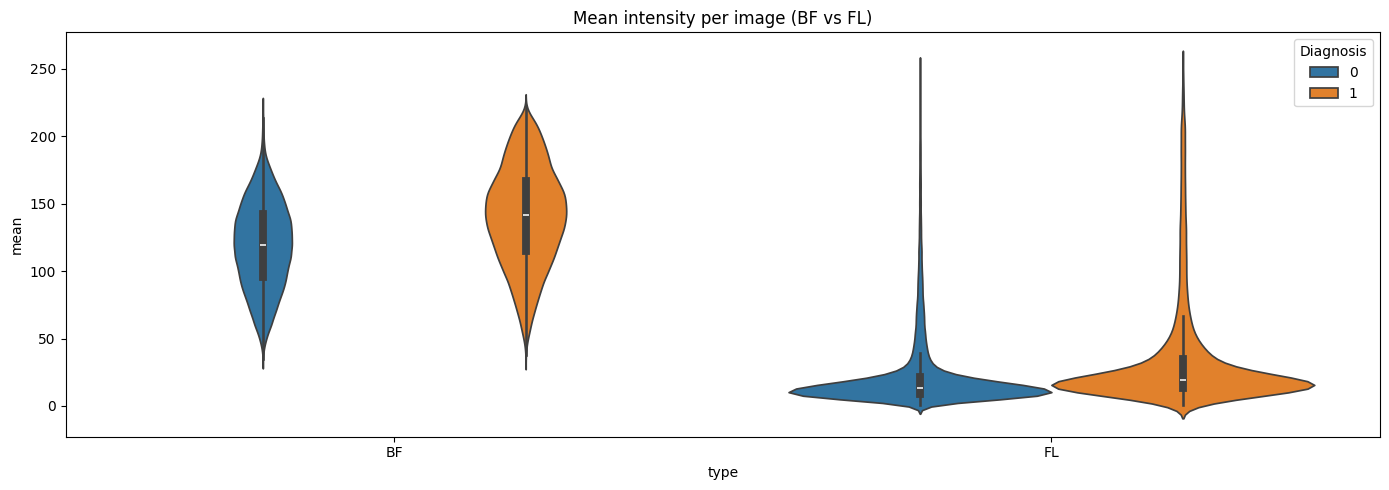

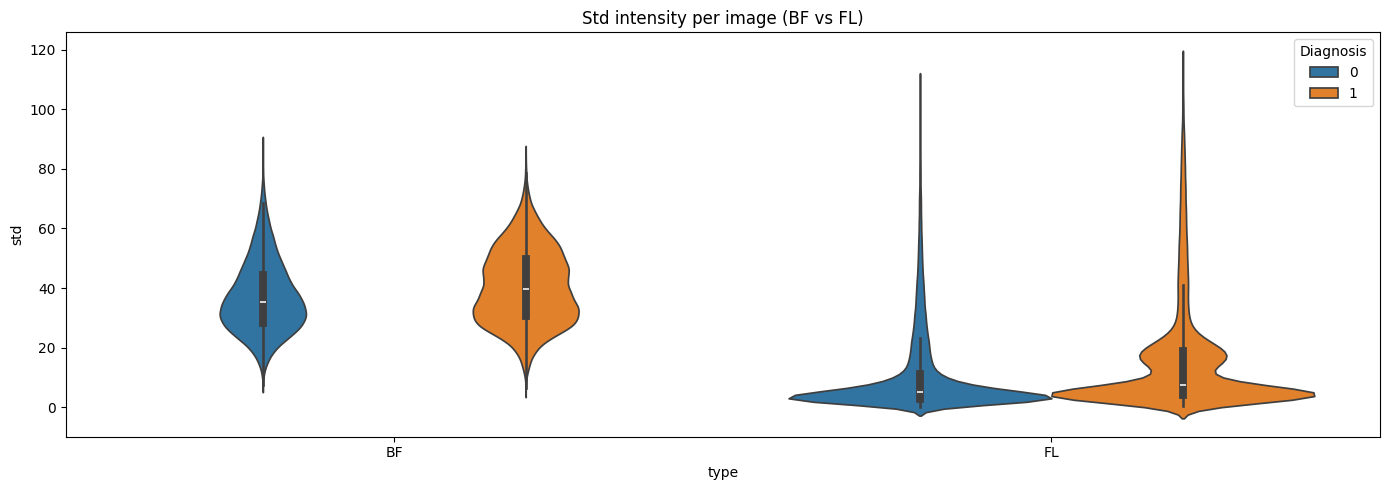

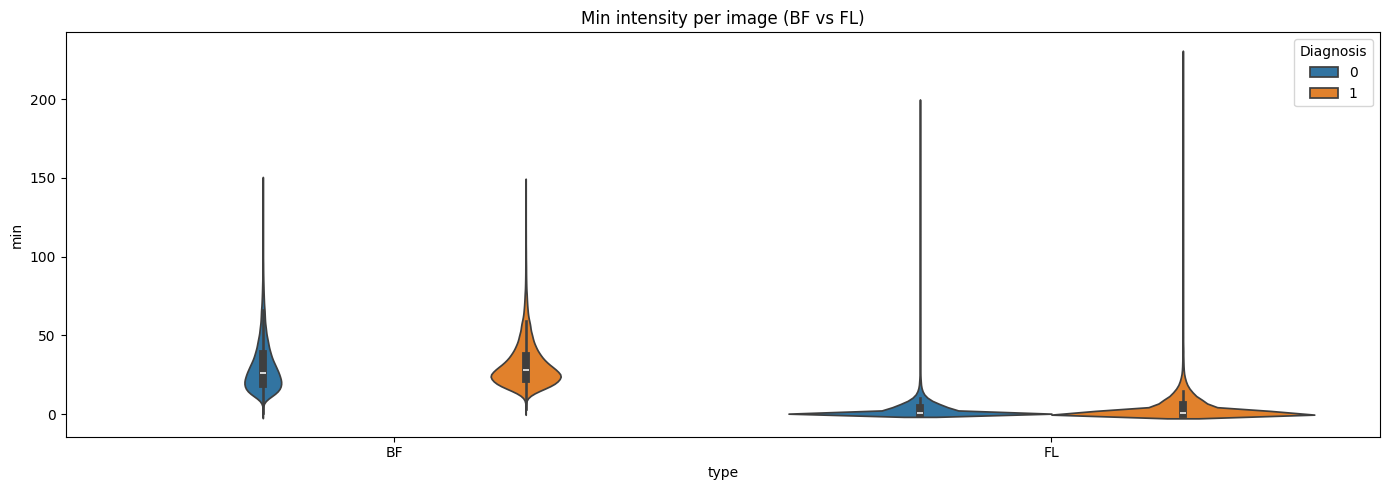

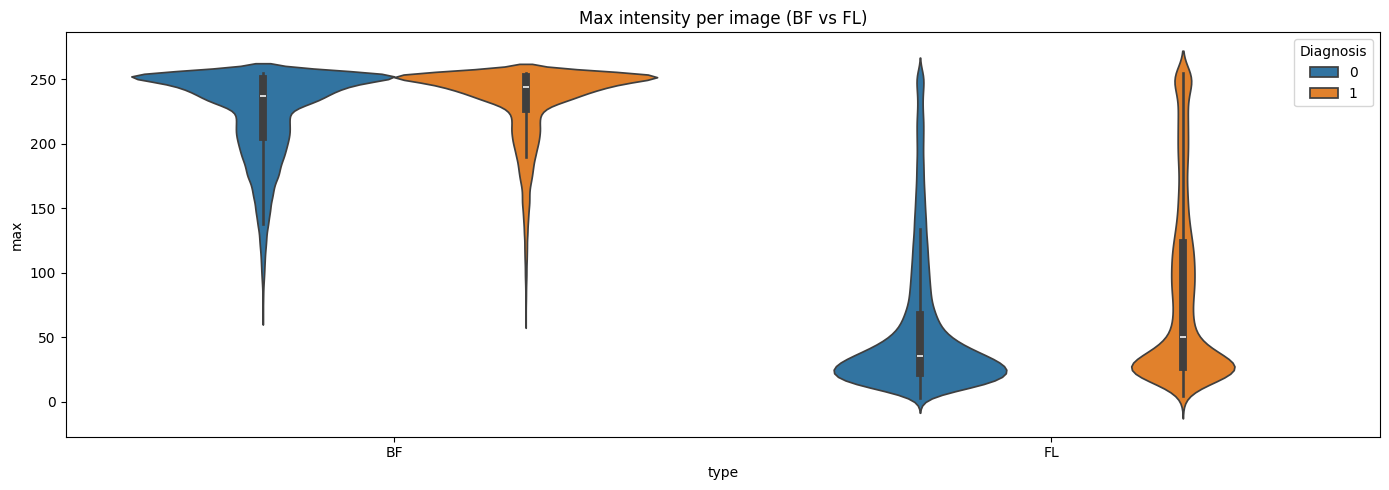

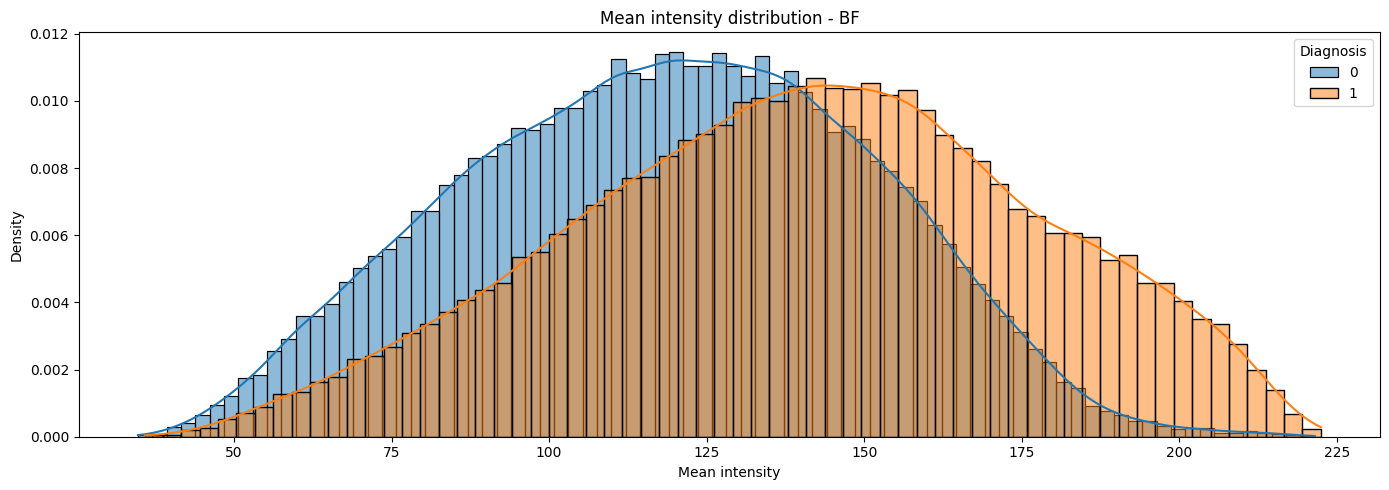

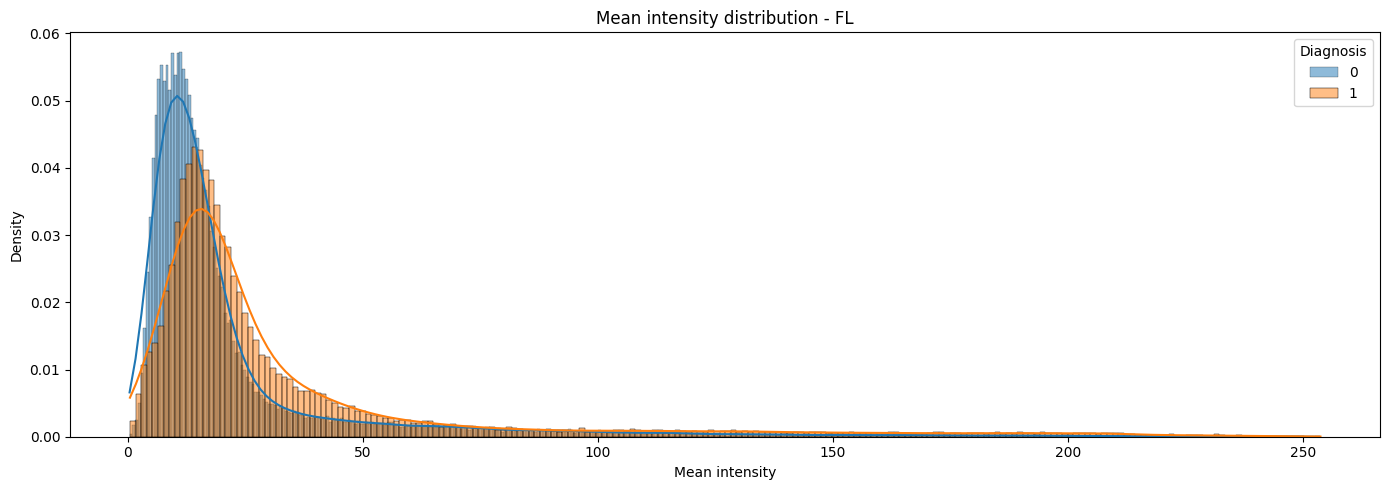

In [29]:
plot_image_intensity_stats('image_intensity_stats.csv')

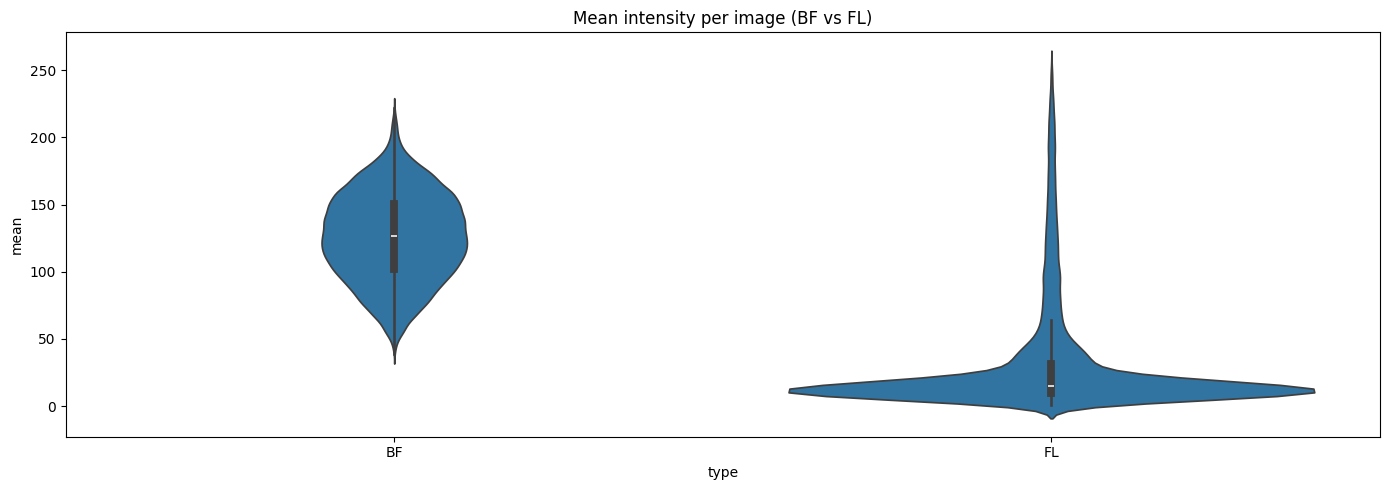

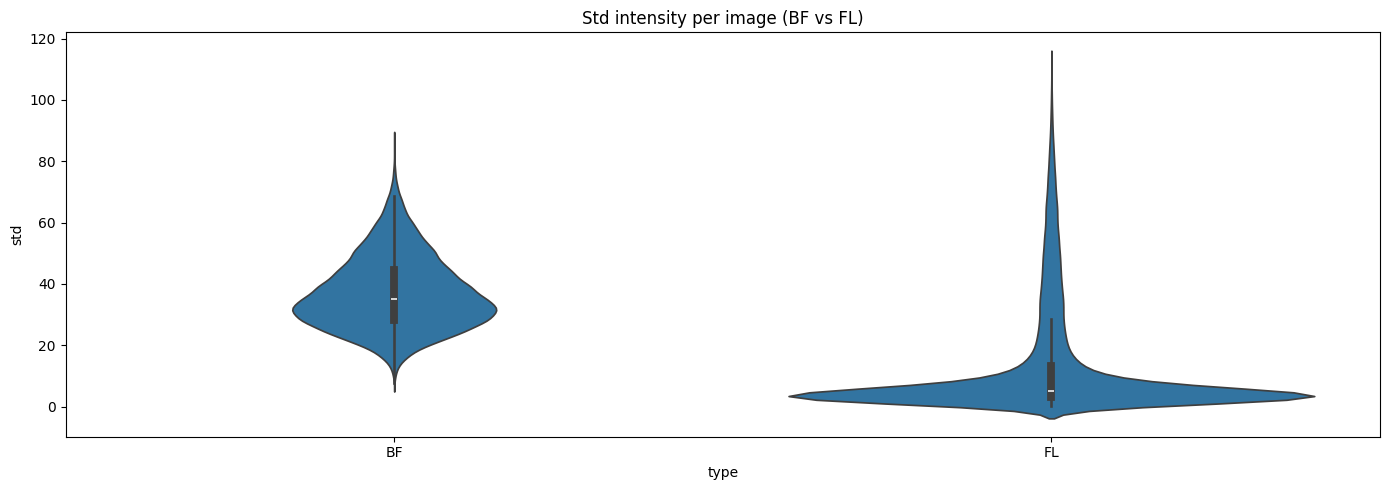

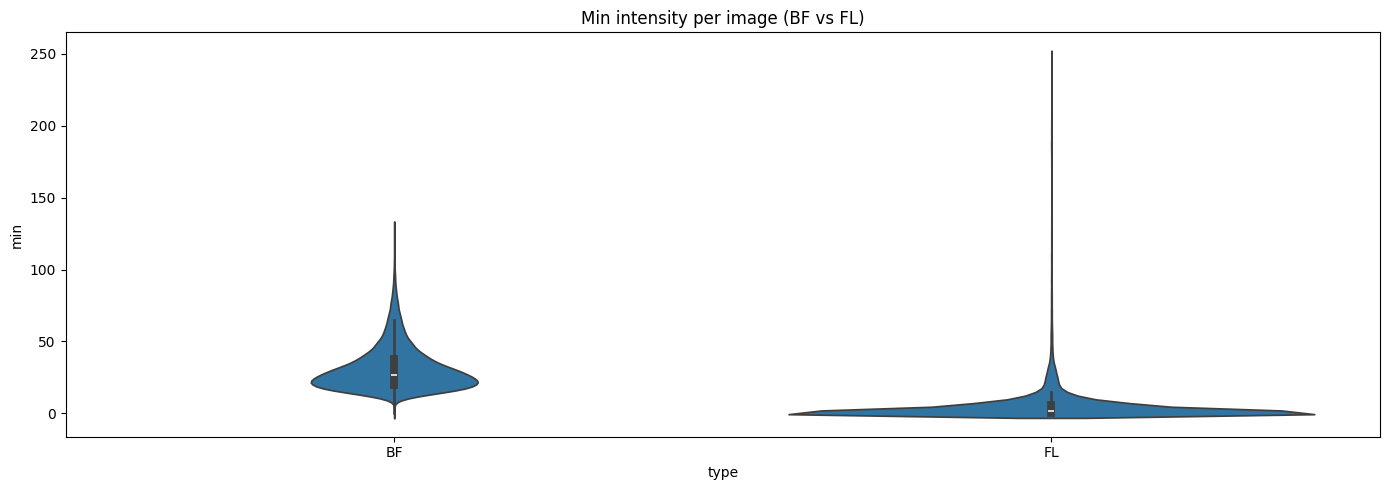

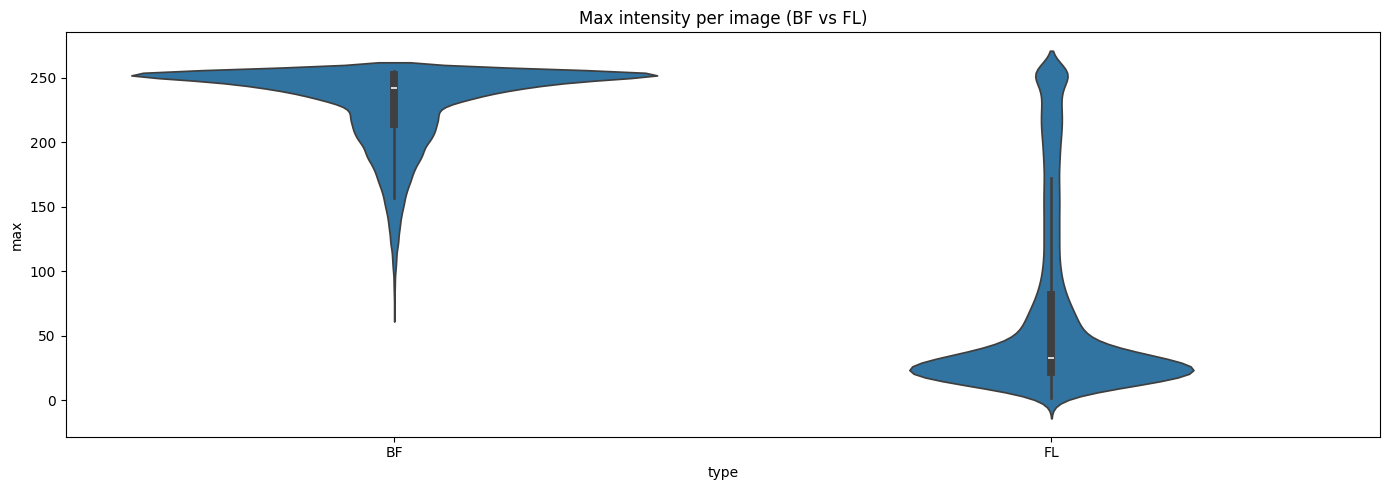

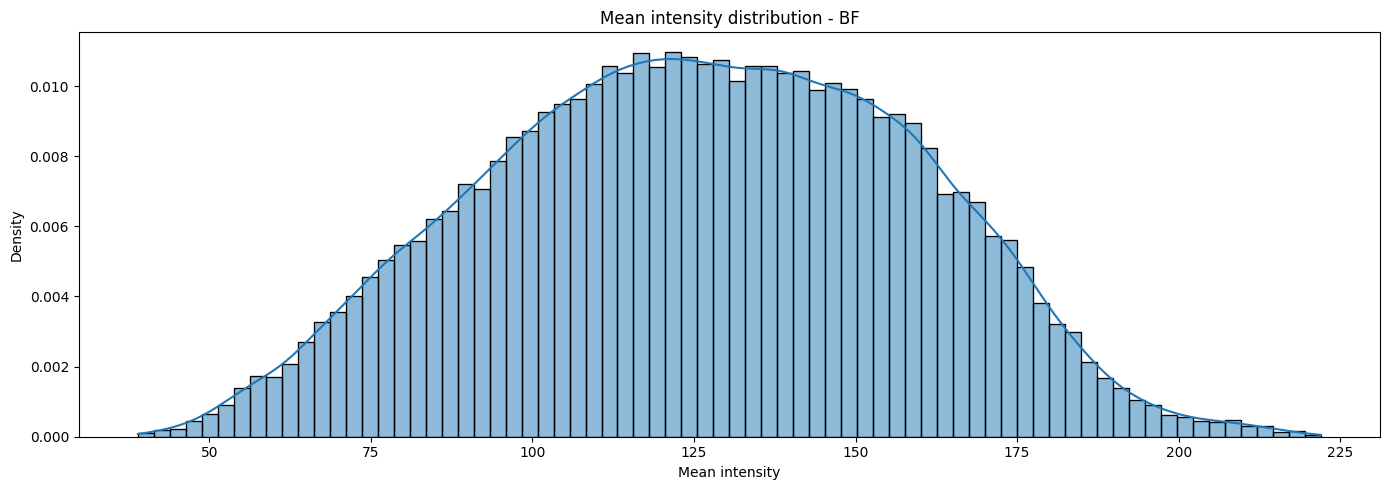

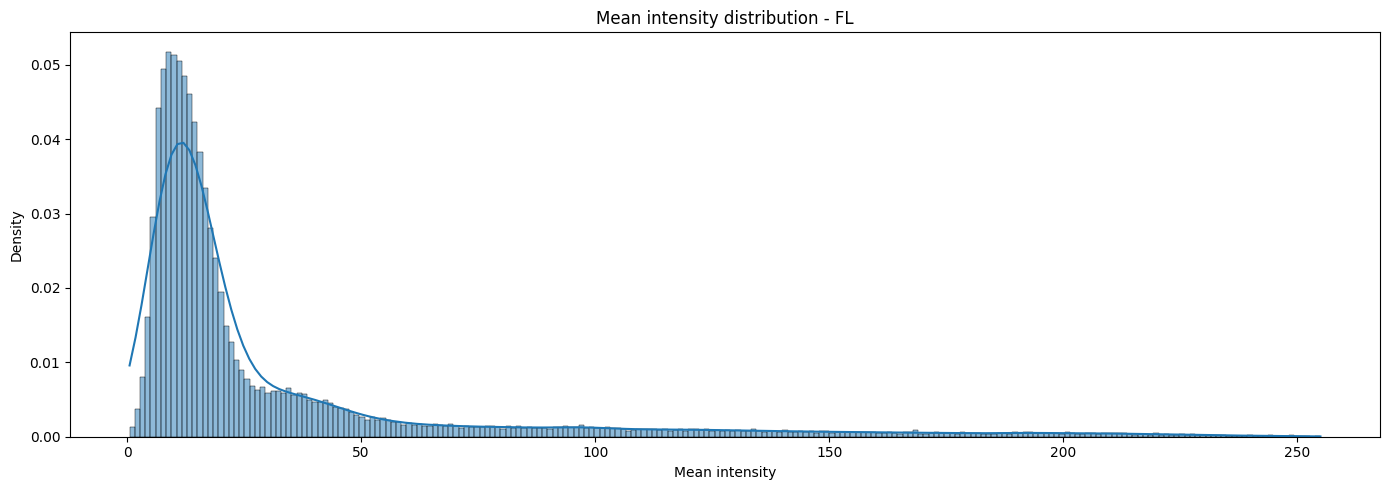

In [30]:
plot_image_intensity_stats_unlabeled('test_image_intensity_stats.csv')

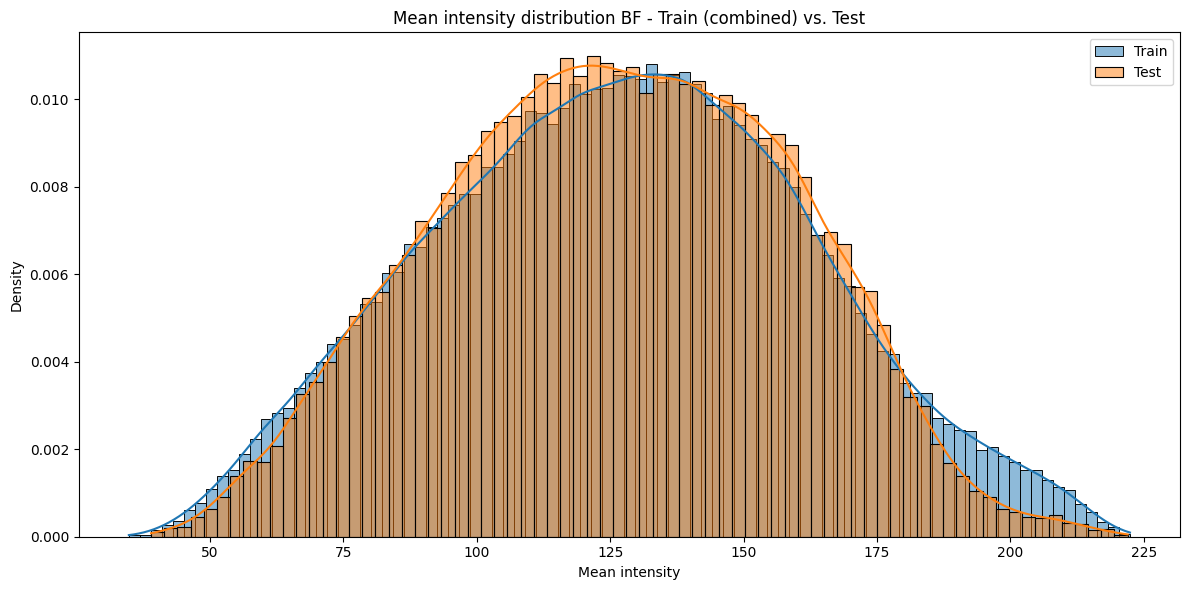

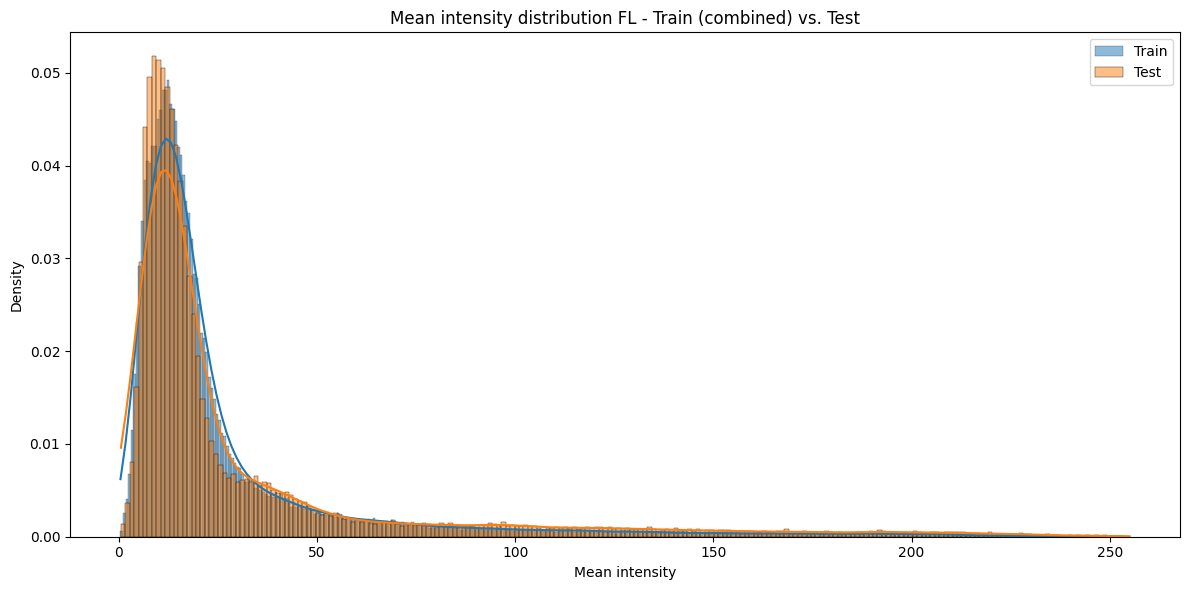

In [31]:
plot_train_vs_test_mean_histograms_combined('image_intensity_stats.csv', 'test_image_intensity_stats.csv')

In [74]:
def get_top_images_by_mean_intensity(stats_csv_path,
                                     fl_image_dir,
                                     bf_image_dir,
                                     top_n=5,
                                     show_images=False,
                                     diagnosis_filter=None,
                                     mode='FL'):
    
    # Load and filter data
    stats_df = pd.read_csv(stats_csv_path)
    df = stats_df[stats_df['type'] == mode]
    if diagnosis_filter in [0, 1]:
        df = df[df['label'] == diagnosis_filter]

    top_images = df.sort_values(by='mean', ascending=False).head(top_n)

    if show_images:
        for _, row in top_images.iterrows():
            name = row['image']
            bf_path = os.path.join(bf_image_dir, name)
            fl_path = os.path.join(fl_image_dir, name)

            bf_img = Image.open(bf_path).convert("RGB")
            fl_img = Image.open(fl_path).convert("RGB")

            # Convert to numpy arrays for display
            bf_np = np.array(bf_img)
            fl_np = np.array(fl_img)

            # Plot only the original images
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            fig.suptitle(f"{name} | Patient: {row['patient_id']} | Label: {row['label']}")
            axs[0].imshow(bf_np)
            axs[0].set_title("BF Original")
            axs[0].axis('off')
            axs[1].imshow(fl_np)
            axs[1].set_title("FL Original")
            axs[1].axis('off')
            plt.tight_layout()
            plt.show()

    return top_images[['image', 'mean', 'patient_id', 'label']]


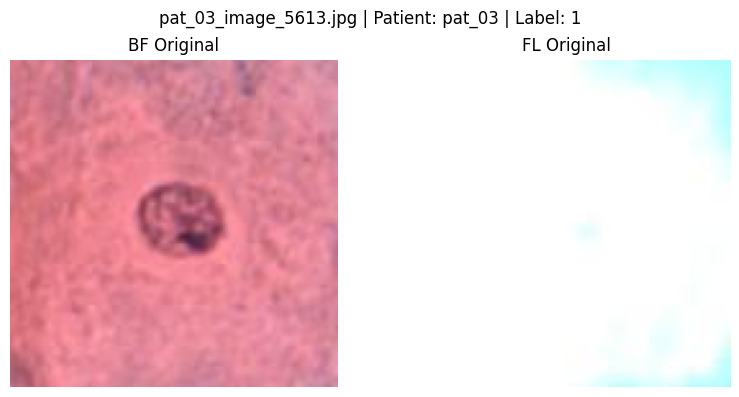

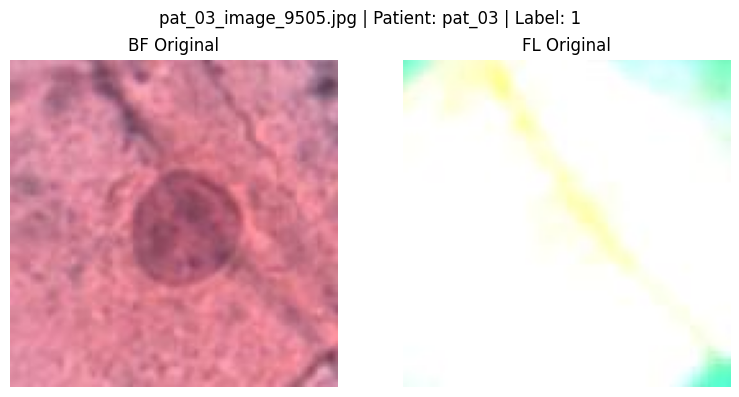

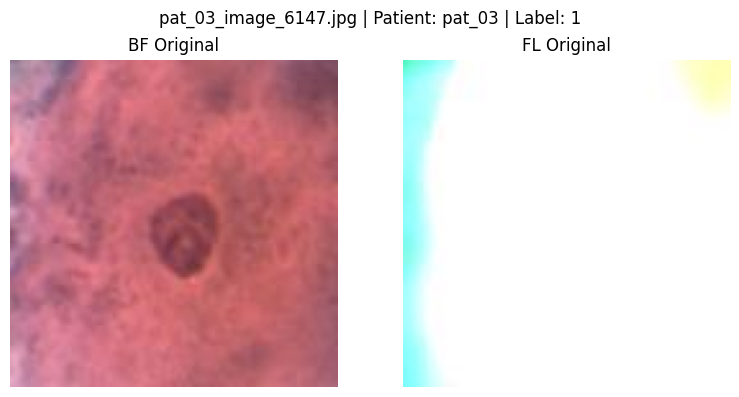

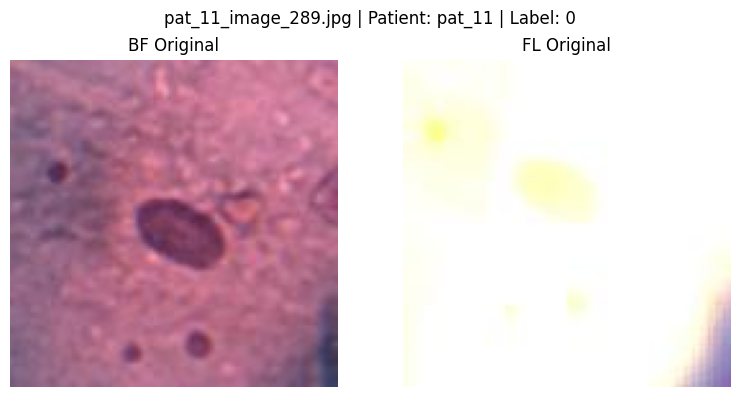

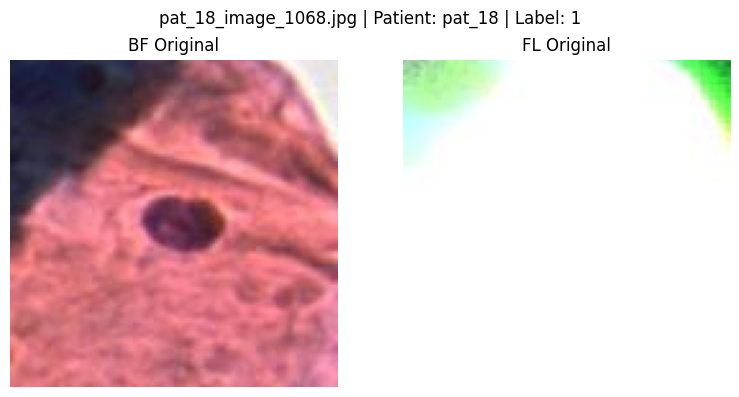

In [75]:
top_images = get_top_images_by_mean_intensity(stats_csv_path='image_intensity_stats.csv', fl_image_dir=FL_PATH, bf_image_dir=BF_PATH, show_images=True, mode='FL')

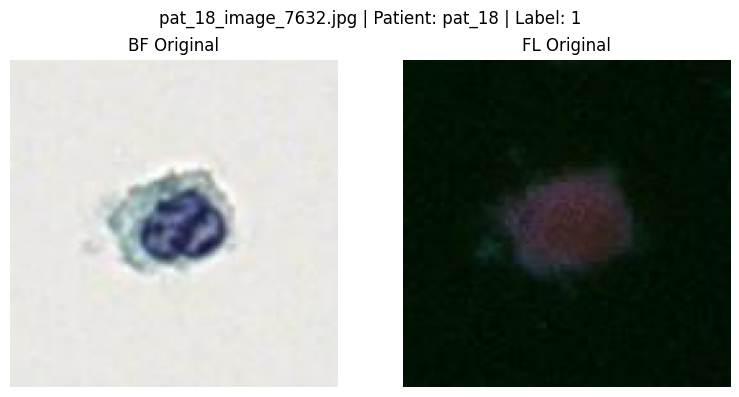

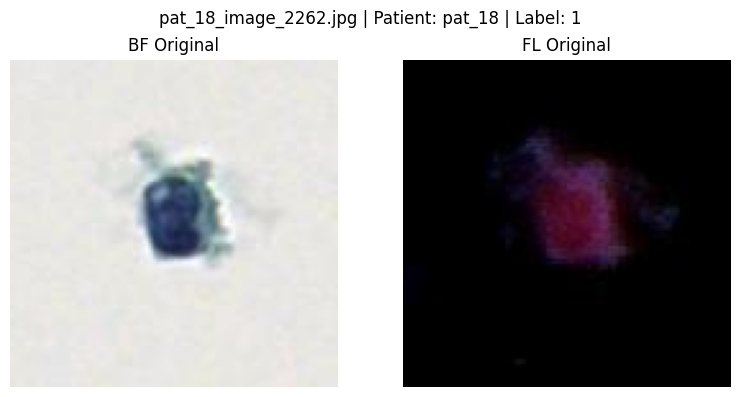

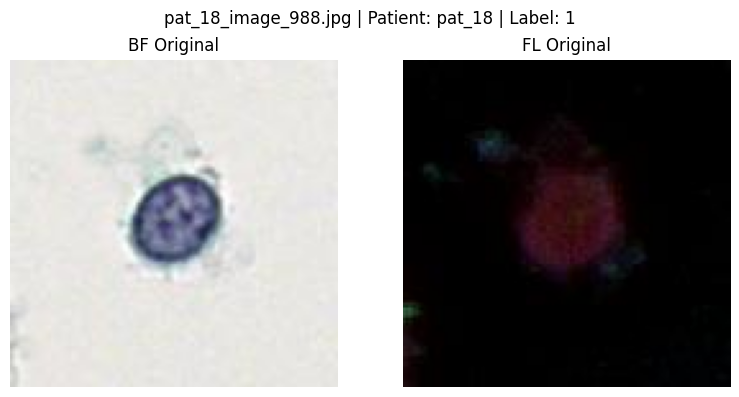

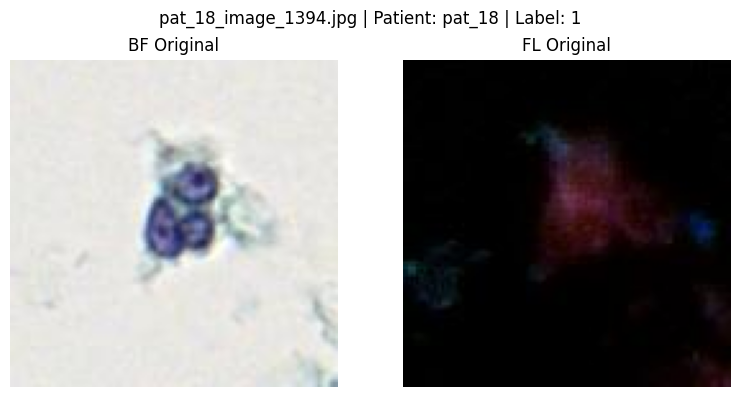

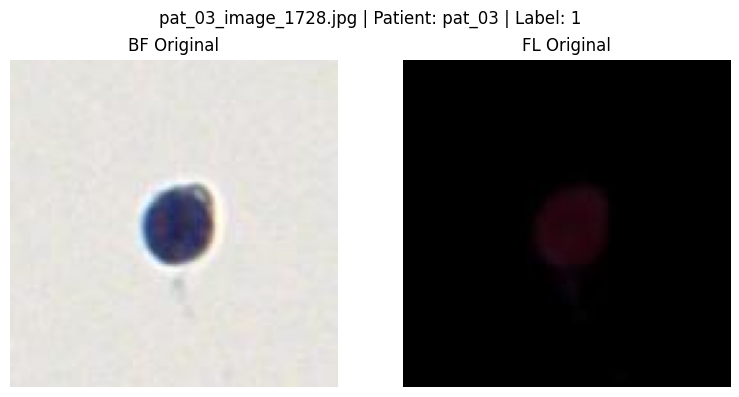

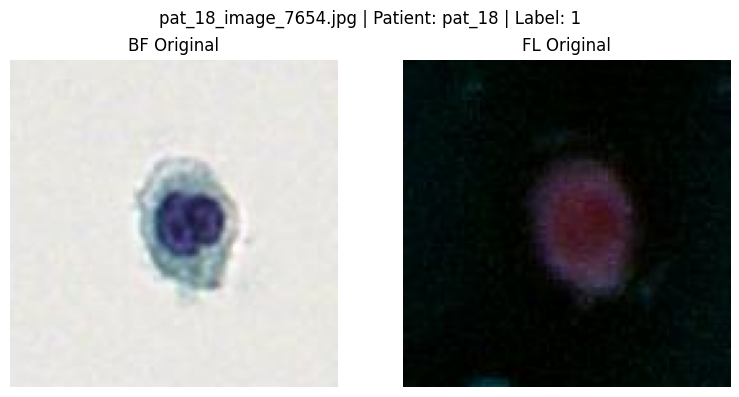

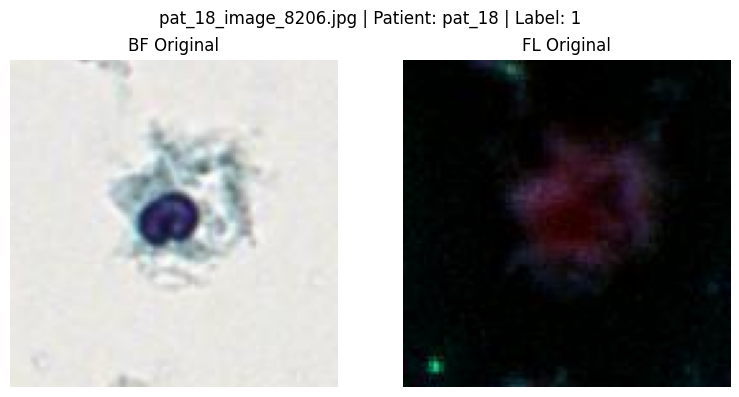

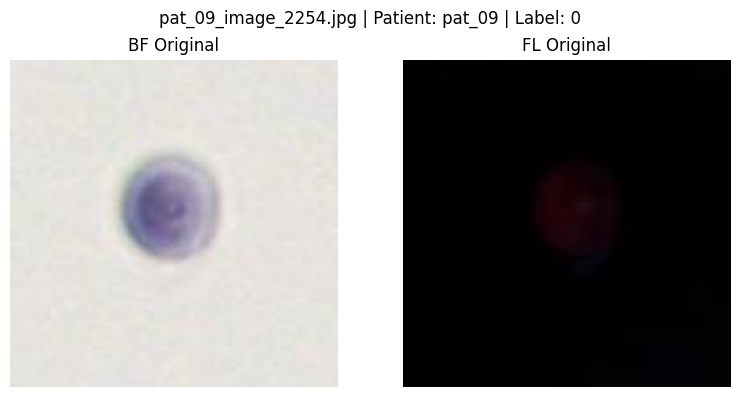

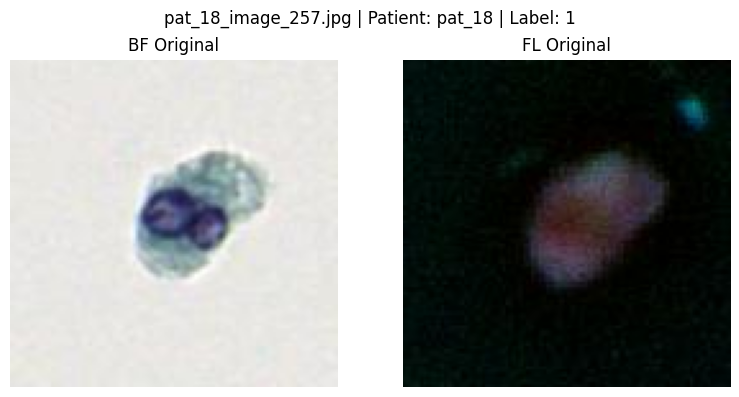

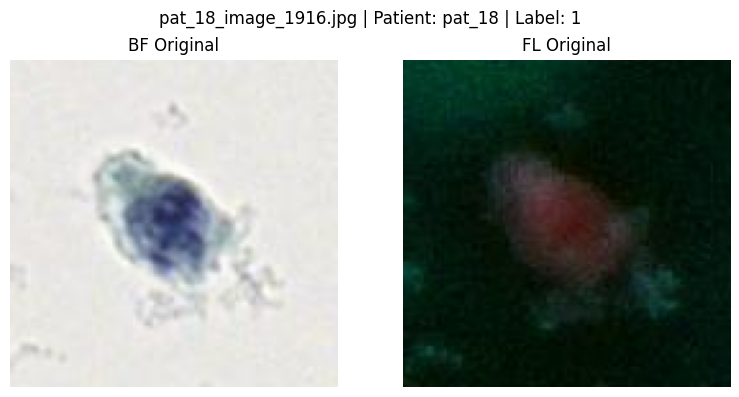

In [76]:
top_images = get_top_images_by_mean_intensity(stats_csv_path='image_intensity_stats.csv', top_n=10, fl_image_dir=FL_PATH, bf_image_dir=BF_PATH, show_images=True, mode='BF')